In [1]:
from datasets import load_dataset
ds = load_dataset("garage-bAInd/Open-Platypus", split='train')

In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib einops


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
train_val_split = ds.train_test_split(test_size=0.2)

# Extract the training and validation datasets
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

# Print the size of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 19940
Validation set size: 4986


In [4]:
def formatting_func(example):
    text = f"### Question: {example['instruction']}\n ### Answer: {example['output']}"
    return text

In [5]:
print(formatting_func(ds[0]))

### Question: A board game spinner is divided into three parts labeled $A$, $B$  and $C$. The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is the probability of the spinner landing on $C$? Express your answer as a common fraction.
 ### Answer: To find the probability of the spinner landing on $C$, I need to subtract the probabilities of the spinner landing on $A$ and $B$ from $1$, since the sum of the probabilities of all possible outcomes is $1$. I can write this as an equation: $P(C) = 1 - P(A) - P(B)$. I know that $P(A) = \frac{1}{3}$ and $P(B) = \frac{5}{12}$, so I can plug those values into the equation and simplify. I get: $P(C) = 1 - \frac{1}{3} - \frac{5}{12} = \frac{12}{12} - \frac{4}{12} - \frac{5}{12} = \frac{3}{12}$. I can reduce this fraction by dividing the numerator and denominator by $3$, and I get: $P(C) = \frac{1}{4}$. 


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model

In [7]:
base_model_id = "meta-llama/Llama-3.1-8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [64]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token

In [65]:
max_length = 2048 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [66]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/19940 [00:00<?, ? examples/s]

Map:   0%|          | 0/4986 [00:00<?, ? examples/s]

24926


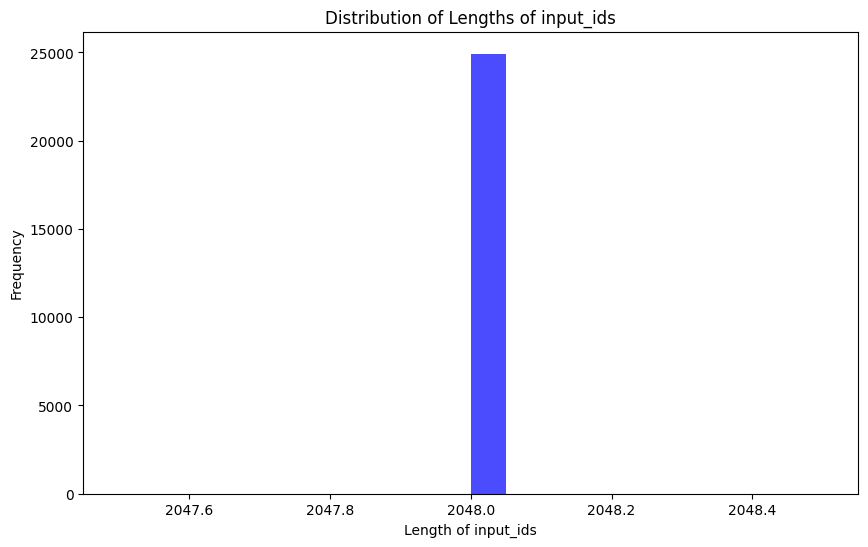

In [67]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [27]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [29]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [35]:
!pip install accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [38]:
from accelerate import Accelerator

accelerator = Accelerator()

In [40]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 22030336 || all params: 4562630656 || trainable%: 0.4828428523143645


In [41]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): PeftModelForCausalLM(
          (base_model): LoraModel(
            (model): PeftModelForCausalLM(
              (base_model): LoraModel(
                (model): PeftModelForCausalLM(
                  (base_model): LoraModel(
                    (model): LlamaForCausalLM(
                      (model): LlamaModel(
                        (embed_tokens): Embedding(128256, 4096)
                        (layers): ModuleList(
                          (0-31): 32 x LlamaDecoderLayer(
                            (self_attn): LlamaSdpaAttention(
                              (q_proj): lora.Linear4bit(
                                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                                (lora_dropout): ModuleDict(
                                  (default): Dropout(p=0.05, inplace=False)
                     

In [42]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "llama-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yinghal (yinghal-university-of-michigan). Use `wandb login --relogin` to force relogin


In [43]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "llama-finetune"
base_model_name = "meta-llama/Llama-3.1-8B"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5,
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
